## RAG Agent

<center>

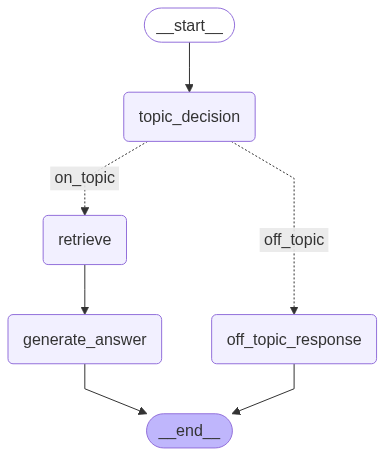

</center>

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

# Create embedding function
embedding_function = OpenAIEmbeddings()

# Example product and store info documents
docs = [
    Document(
        page_content="TechZone is owned by Priya Sharma, a former engineer who started the store to bring the latest gadgets to her hometown. She has over 15 years of experience in consumer electronics.",
        metadata={"source": "owner.txt"},
    ),
    Document(
        page_content="TechZone sells a wide range of products including smartphones, laptops, gaming consoles, and accessories. Smartphone prices start at ₹15,000, laptops range from ₹40,000 to ₹1,20,000, and gaming consoles are priced between ₹35,000 and ₹60,000.",
        metadata={"source": "products.txt"},
    ),
    Document(
        page_content="TechZone is open from Tuesday to Sunday. Weekday hours are 10:00 AM to 8:00 PM, and weekend hours extend to 9:00 PM. The store is closed on Mondays.",
        metadata={"source": "hours.txt"},
    ),
    Document(
        page_content="TechZone offers seasonal discounts during major festivals like Diwali and Christmas. Customers can also sign up for a membership program that gives 10% off on all accessories year-round.",
        metadata={"source": "offers.txt"},
    ),
]

# Create a Chroma vector database
db = Chroma.from_documents(docs, embedding_function)
retriever = db.as_retriever(search_kwargs={"k": 2})

In [4]:
from langchain import hub
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
prompt = hub.pull("rlm/rag-prompt")

llm = ChatOpenAI(model="gpt-4o-mini")


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = prompt | llm

/Users/g/miniconda3/envs/langgraph/lib/python3.11/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [5]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain.schema import Document


class AgentState(TypedDict):
    messages: list[BaseMessage]
    documents: list[Document]
    on_topic: str

In [8]:
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate


class GradeQuestion(BaseModel):
    """Boolean value to check whether a question is releated to the TechZone"""

    score: str = Field(
        description="Question is about techzone gadget shop? If yes -> 'Yes' if not -> 'No'"
    )


def question_classifier(state: AgentState):
    question = state["messages"][-1].content

    system = """You are a classifier that determines whether a user's question is about one of the following topics:

    1. Information about the owner of TechZone, which is Priya Sharma.
    2. Prices of gadgests at TechZone.
    3. Opening hours of TechZone.

    If the question IS about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'. Remember, ONLY YES or NO, nothing else in the reponse!
    """

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "User question: {question}"),
        ]
    )

    llm = ChatOpenAI(model="gpt-4o-mini")
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({"question": question})
    print("RESULT", result)
    state["on_topic"] = result.score
    return state

In [9]:
def on_topic_router(state):
    on_topic = state["on_topic"]
    if on_topic.lower() == "yes":
        return "on_topic"
    return "off_topic"


def retrieve(state):
    question = state["messages"][-1].content
    documents = retriever.invoke(question)
    state["documents"] = documents
    return state


def generate_answer(state):
    question = state["messages"][-1].content
    documents = state["documents"]
    generation = rag_chain.invoke({"context": documents, "question": question})
    state["messages"].append(generation)
    return state


def off_topic_response(state: AgentState):
    state["messages"].append(AIMessage(content="I can't respond to that!"))
    return state

In [10]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("topic_decision", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve", retrieve)
workflow.add_node("generate_answer", generate_answer)

workflow.add_conditional_edges(
    "topic_decision",
    on_topic_router,
    {
        "on_topic": "retrieve",
        "off_topic": "off_topic_response",
    },
)

workflow.add_edge("retrieve", "generate_answer")
workflow.add_edge("generate_answer", END)
workflow.add_edge("off_topic_response", END)

workflow.set_entry_point("topic_decision")
graph = workflow.compile()

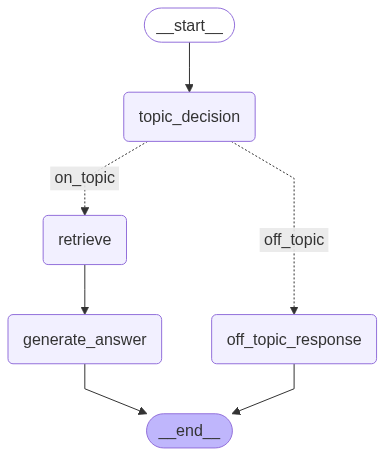

In [11]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [12]:
graph.invoke(
    input={
        "messages": [HumanMessage(content="When does the TechZone open?")]
    }
)

RESULT score='Yes'


{'messages': [HumanMessage(content='When does the TechZone open?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='TechZone is open from Tuesday to Sunday, with weekday hours from 10:00 AM to 8:00 PM and weekend hours until 9:00 PM. It is closed on Mondays.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 175, 'total_tokens': 215, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C5FtXChBCUOZKkUCQevoRSK7sqw7v', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--9e3611d0-cd89-433b-93df-ebf597cd9d83-0', usage_metadata={'input_tokens': 175, 'output_tokens': 40, 'total_tokens': 215, 'input_token_details': {'audio': 0, 'cache_read':

In [13]:
graph.invoke(
    input={"messages": [HumanMessage(content="What is articial intelligence?")]}
)

RESULT score='No'


{'messages': [HumanMessage(content='What is articial intelligence?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I can't respond to that!", additional_kwargs={}, response_metadata={})],
 'on_topic': 'No'}

### Retriever As Tool

In [14]:
from langchain.tools.retriever import create_retriever_tool
from langchain_core.tools import tool

retriever_tool = create_retriever_tool(
    retriever,
    "retriever_tool",
    "Information related to Pricing, Opening hours of the owner of the TechZone",
)


@tool
def off_topic():
    """Catch all Questions NOT related to Pricing, Opening hours of the owner of the TechZone"""
    return "Forbidden - do not respond to the user"


tools = [retriever_tool, off_topic]

In [15]:
from typing import Sequence, TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [16]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI


def agent(state):
    messages = state["messages"]
    model = ChatOpenAI()
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    return {"messages": [response]}


def should_continue(state) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [17]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

In [18]:
workflow = StateGraph(AgentState)

workflow.add_node("agent", agent)

tool_node = ToolNode(tools)
workflow.add_node("tools", tool_node)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

graph = workflow.compile()

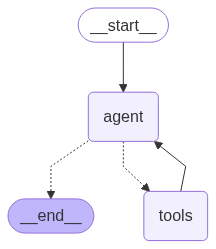

In [19]:
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [20]:
graph.invoke(
    input={"messages": [HumanMessage(content="How will the weather be tommorrow?")]}
)

{'messages': [HumanMessage(content='How will the weather be tommorrow?', additional_kwargs={}, response_metadata={}, id='902b94f7-a7d5-4bca-8cbe-d4269a499e17'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_i2JGvhcjniRF4QrSdZnVqWpq', 'function': {'arguments': '{}', 'name': 'off_topic'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 100, 'total_tokens': 110, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C5FwL4v7sP0g0hCedgDvBy91eKuhK', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4c1c0aa6-9d6e-4864-81d0-b564a96746d5-0', tool_calls=[{'name': 'off_topic', 'args': {}, 'id': 'call_i2JGvhcjniRF4QrSdZnVqWpq', 'type': 'tool_

In [21]:
graph.invoke(
    input={
        "messages": [HumanMessage(content="When does the techzone shop open?")]
    }
)

{'messages': [HumanMessage(content='When does the techzone shop open?', additional_kwargs={}, response_metadata={}, id='0aa6cf66-555d-42f4-a1f9-450fa13eb4c0'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_RwB7x1Z3erj2GXvVNUjCjfBs', 'function': {'arguments': '{"query":"TechZone shop opening hours"}', 'name': 'retriever_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 99, 'total_tokens': 119, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C5Fww2duzH99IkWd9x18Y1WyPCApo', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c4091be3-21cc-4df6-90b6-a5450df31335-0', tool_calls=[{'name': 'retriever_tool', 'args': {'query': 'T